# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
>
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>

### Python Dependencies

In [1]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Scooter Planar Model
================================

### Introduction

We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

  - The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

  - Two fixed wheels (their orientation with respect to the frame does not change).
    They are parallel and located at opposite ends of the frame.
    
Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.

### Parameter Definition

From now on, we assume that the seat frame length is $\ell = 50 \mbox{ cm}$ and the wheel radius is $r = 12.5 \mbox{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values.

In [77]:
# 🔓
l = float(50 / 100)
r = float(12.5 / 100)

### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the scooter (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [42]:
# 🔓
def draw_scooter(x, y, theta):
    translation = array([[x], [y]])
    rotation = array([
        [cos(theta), -sin(theta)],
        [sin(theta),  cos(theta)]
    ])

    # Left pad
    corners = [[0, 0], [-r, l/2], [r, l/2]]
    corners += [corners[0]]
    corners = array(corners).T
    corners = rotation @ corners + translation
    xc = corners[0]
    yc = corners[1]
    fill(xc, yc, color="red", zorder=10)

    # Right pad
    corners = [[0, 0], [r, -l/2], [-r, -l/2]]
    corners += [corners[0]]
    corners = array(corners).T
    corners = rotation @ corners + translation
    xc = corners[0]
    yc = corners[1]
    fill(xc, yc, color="red", zorder=10)

    # Fixed Wheels
    wheel_left_xy_start = rotation @ [[-r], [-l/2]] + translation
    wheel_left_xy_end = rotation @ [[r], [-l/2]] + translation
    plot([wheel_left_xy_start[0], wheel_left_xy_end[0]], [wheel_left_xy_start[1], wheel_left_xy_end[1]], color="black",linewidth=5, zorder=20)

    wheel_right_xy_start = rotation @ [[-r], [l/2]] + translation
    wheel_right_xy_end = rotation @ [[r], [l/2]] + translation
    plot([wheel_right_xy_start[0], wheel_right_xy_end[0]], [wheel_right_xy_start[1], wheel_right_xy_end[1]], color="black", linewidth=5, zorder=20)

    # Forward marker
    xm, ym = rotation @ array([0.5, 0]) + array([x, y])
    plot([xm], [ym], "o", color="green")


🧩 Represent the scooter when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [4]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)

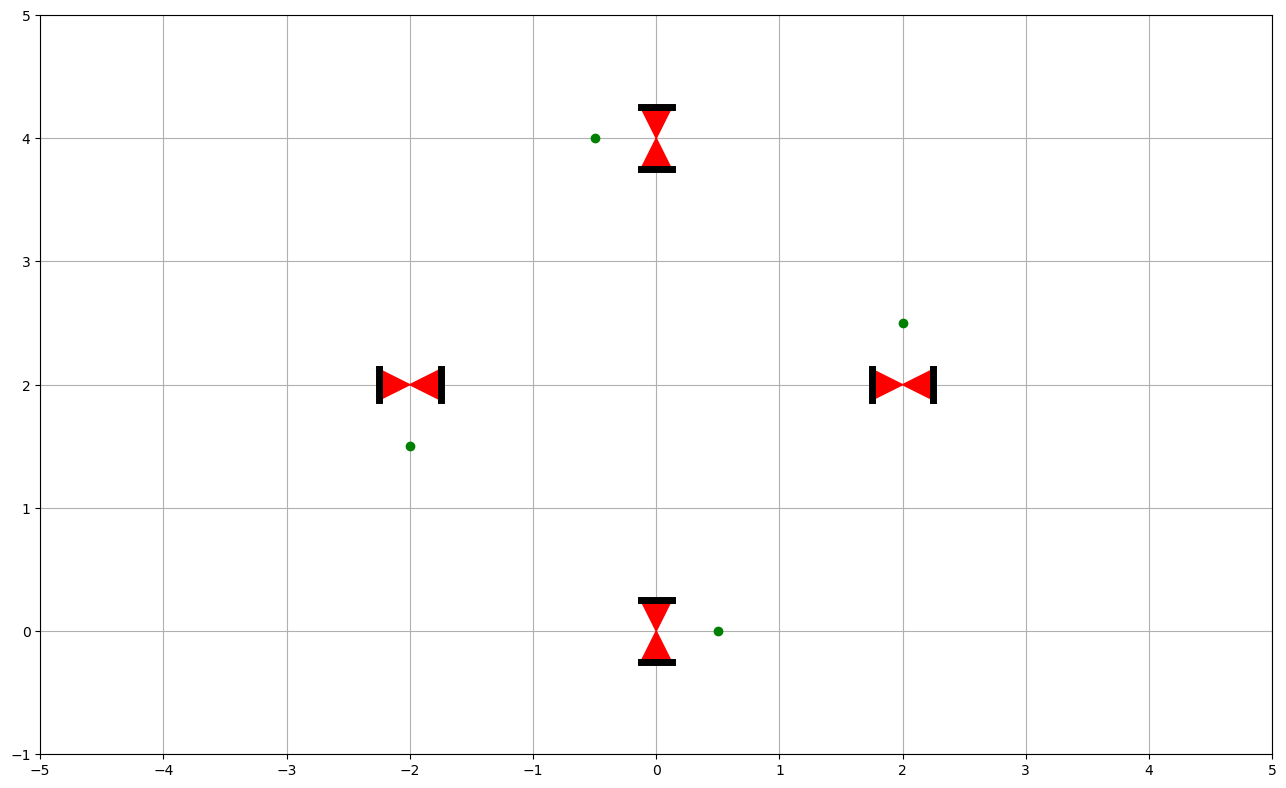

In [5]:
# 🔓
draw_arena(-5, 5, -1, 5)
draw_scooter(0, 0, 0)
draw_scooter(2, 2, pi/2)
draw_scooter(0, 4, pi)
draw_scooter(-2, 2, 3*pi/2)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the scooter).
We also assume that the scooter fixed wheels roll without slipping.

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

🔓
$$
\begin{array}{rcl}
\dot{x} &=& r  \frac{\omega_l + \omega_r}{2} \cos \theta \\
\dot{y} &=& r  \frac{\omega_l + \omega_r}{2} \sin \theta \\
\dot{\theta} &=& r  \frac{\omega_r - \omega_l}{\ell} \\
\end{array}
$$

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

🔓 The vector field is continuously differentiable as a composition of continuously differentiable functions, thus the IVP is well-posed.

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

🔓 When the inputs are constant, it's pretty easy to prove that the derivatives of $x$, $y$ and $\theta$ with respect to $t$ are uniformly bounded ; thus $x$, $y$ and $\theta$ are bounded on any bounded time interval and therefore no finite-time blowup may happen: the maximal solution is global.

The situation is different with state-dependent inputs; for example with $\omega_r = - \omega_l = 0.5 (\ell/r)  \theta^2$, we end up with $\dot{\theta}(t) = \theta(t)^2$ which has a finite-time blowup for some initial values of $\theta$. Thus, the maximal solution may not be global.

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [6]:
def omega(t, xytheta):
    omega_l = (1 - l/4) * pi / r
    omega_r = (1 + l/4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [59]:
# 🔓
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    dx = r * 0.5 * (omega_l + omega_r) * cos(theta)
    dy = r * 0.5 * (omega_l + omega_r) * sin(theta)
    dtheta = r * (omega_r - omega_l) / l
    return array([dx, dy, dtheta])

### Simulation Setup

🧩 Simulate the scooter dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - \ell/4)  \pi / r \mbox{ rad/s}$ and $\omega_r = (1 + \ell/4)  \pi / r \mbox{ rad/s}$.
(Compute the dense outputs.)
   

In [8]:
# 🔓
results = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], dense_output=True)

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

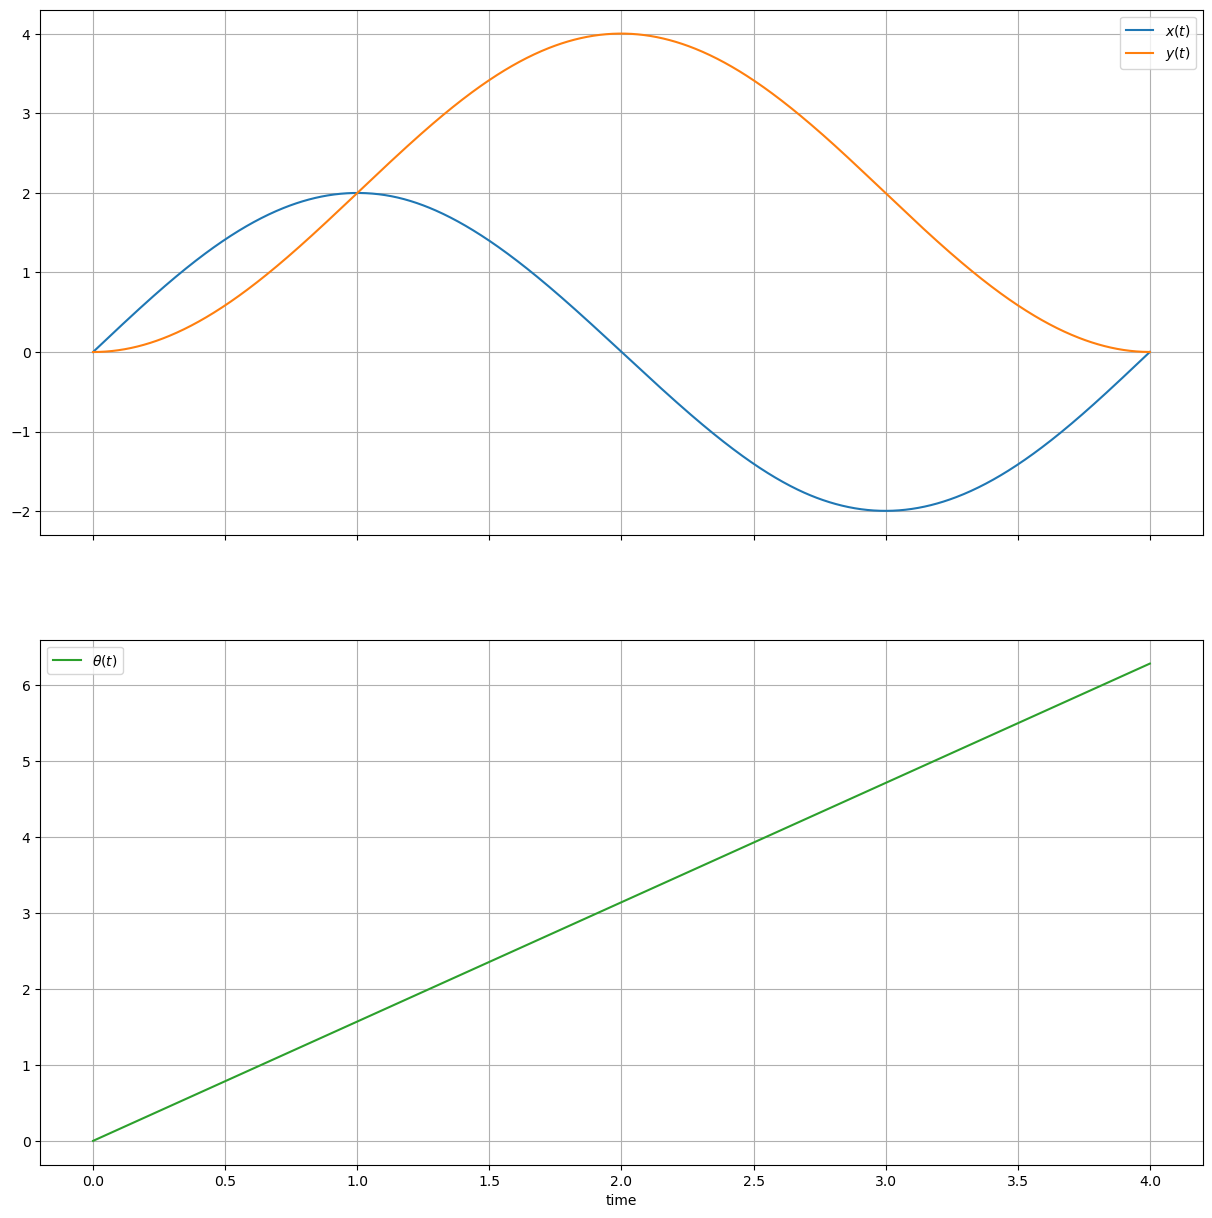

In [9]:
# 🔓
t = linspace(0.0, 4.0, 1000)
x, y, theta = results["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$", color="C2")
ax2.legend()
xlabel("time")
pass

🧩 Use the simulation results to display the robot location every 0.5 second.

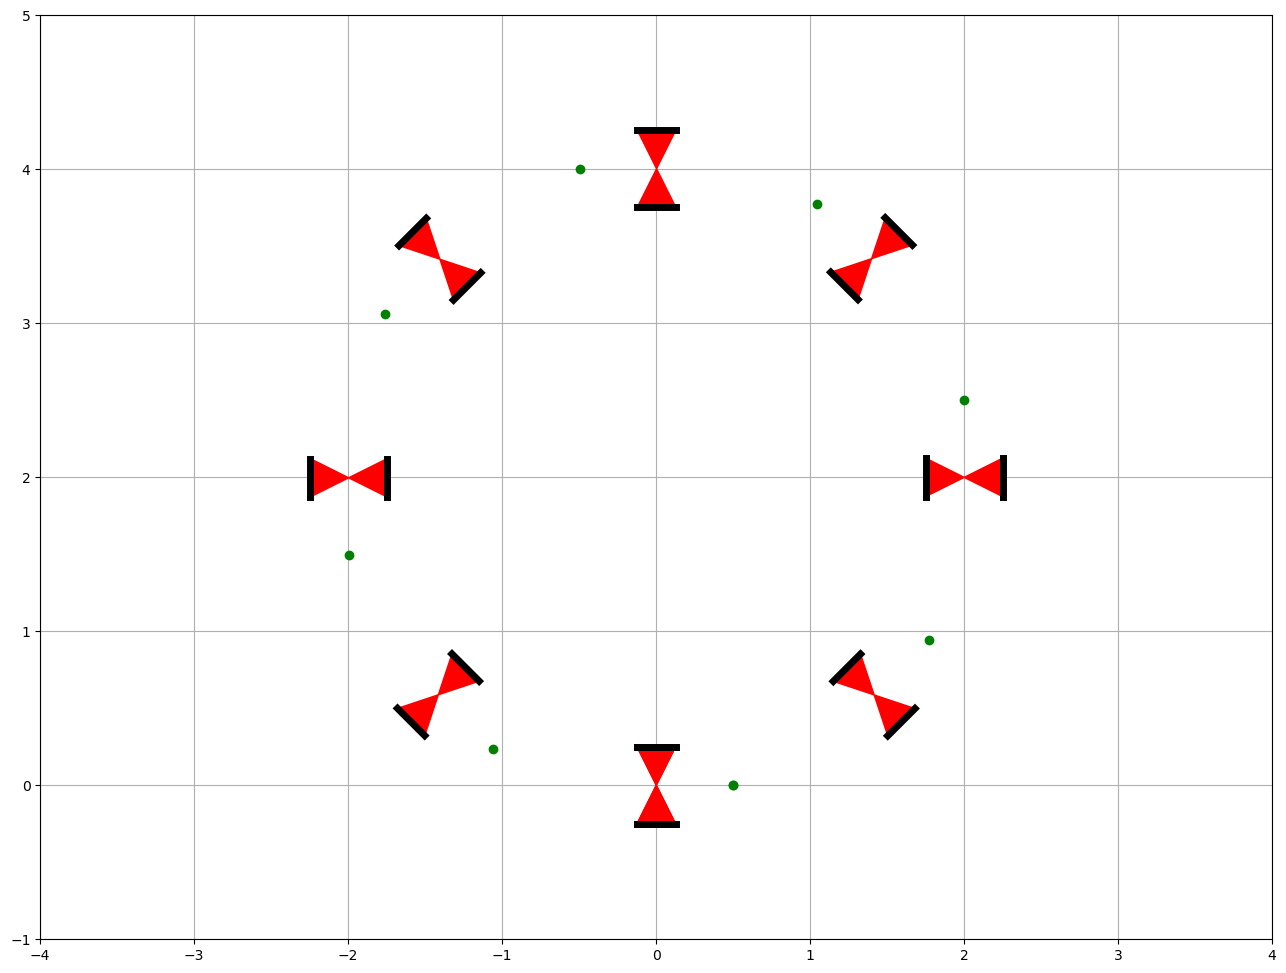

In [10]:
# 🔓
t = linspace(0.0, 4.0, 4*2+1)
sol_t = results["sol"](t)
draw_arena(-4, 4, -1, 5)
for x, y, theta in sol_t.T:
    draw_scooter(x, y, theta)

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$?

$\theta(t) = 2 \pi / 4.0$, $x(t) = 2\sin(2\pi t / 4)$ and $y(t) = -2 \cos(2\pi t / 4)+2$.

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

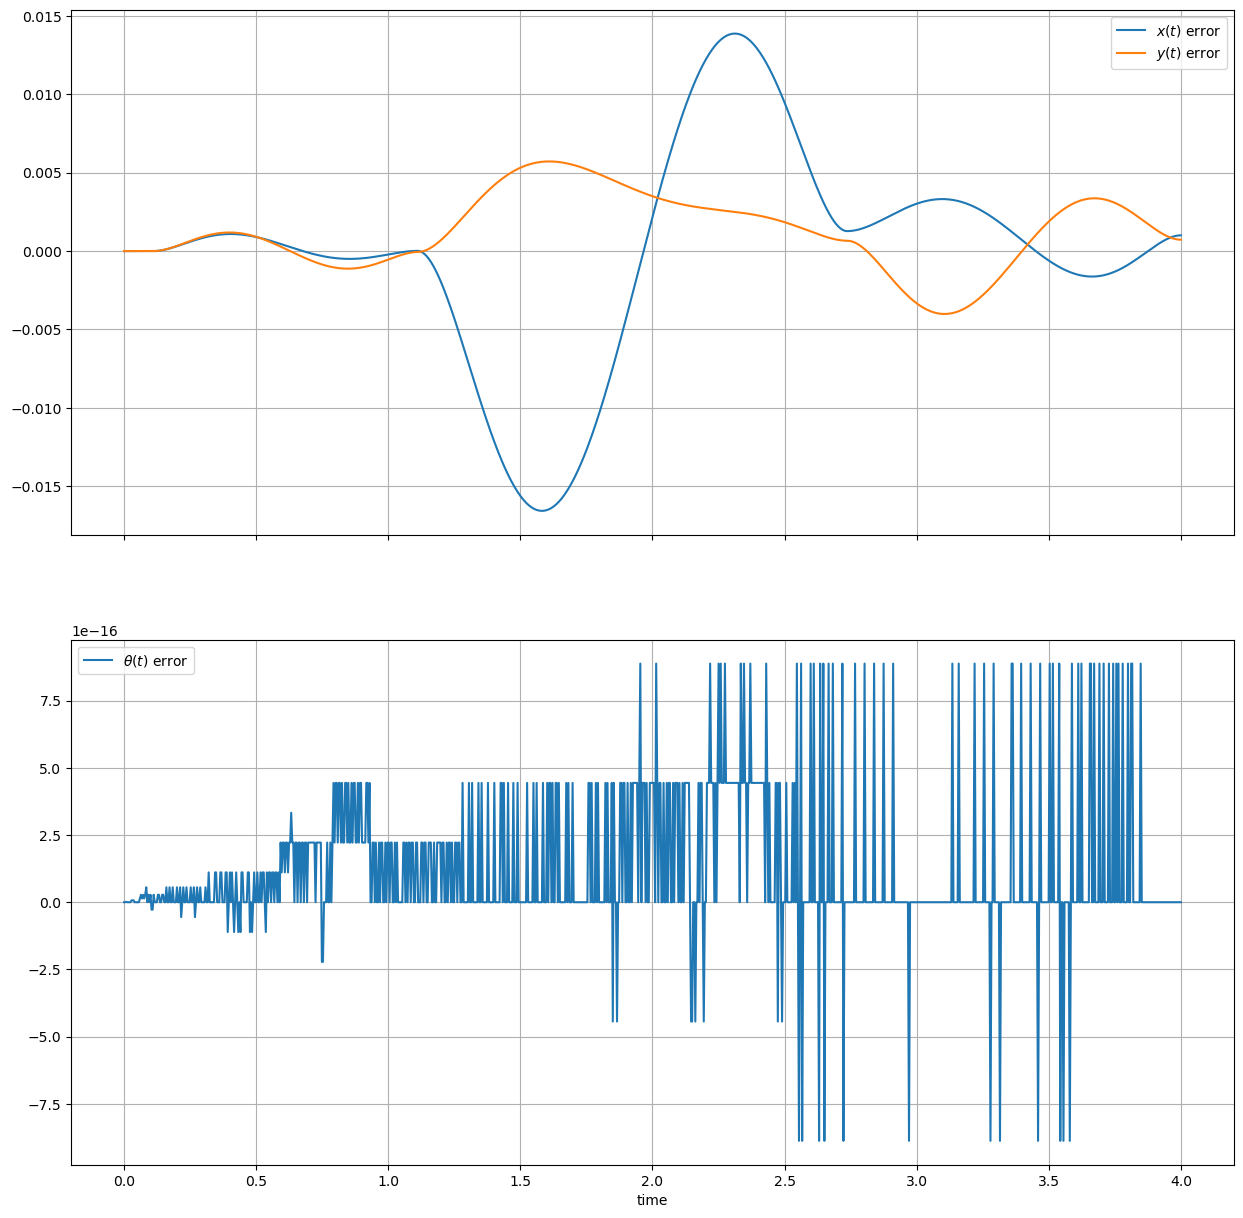

In [11]:
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = results["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t , x_t - 2*sin(2*pi*t/4), label="$x(t)$ error")
ax1.plot(t , y_t + 2*cos(2*pi*t/4) - 2, label="$y(t)$ error")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta_t - 2*pi*t / 4.0, label=r"$\theta(t)$ error")
ax2.legend()
xlabel("time")
pass

🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$.

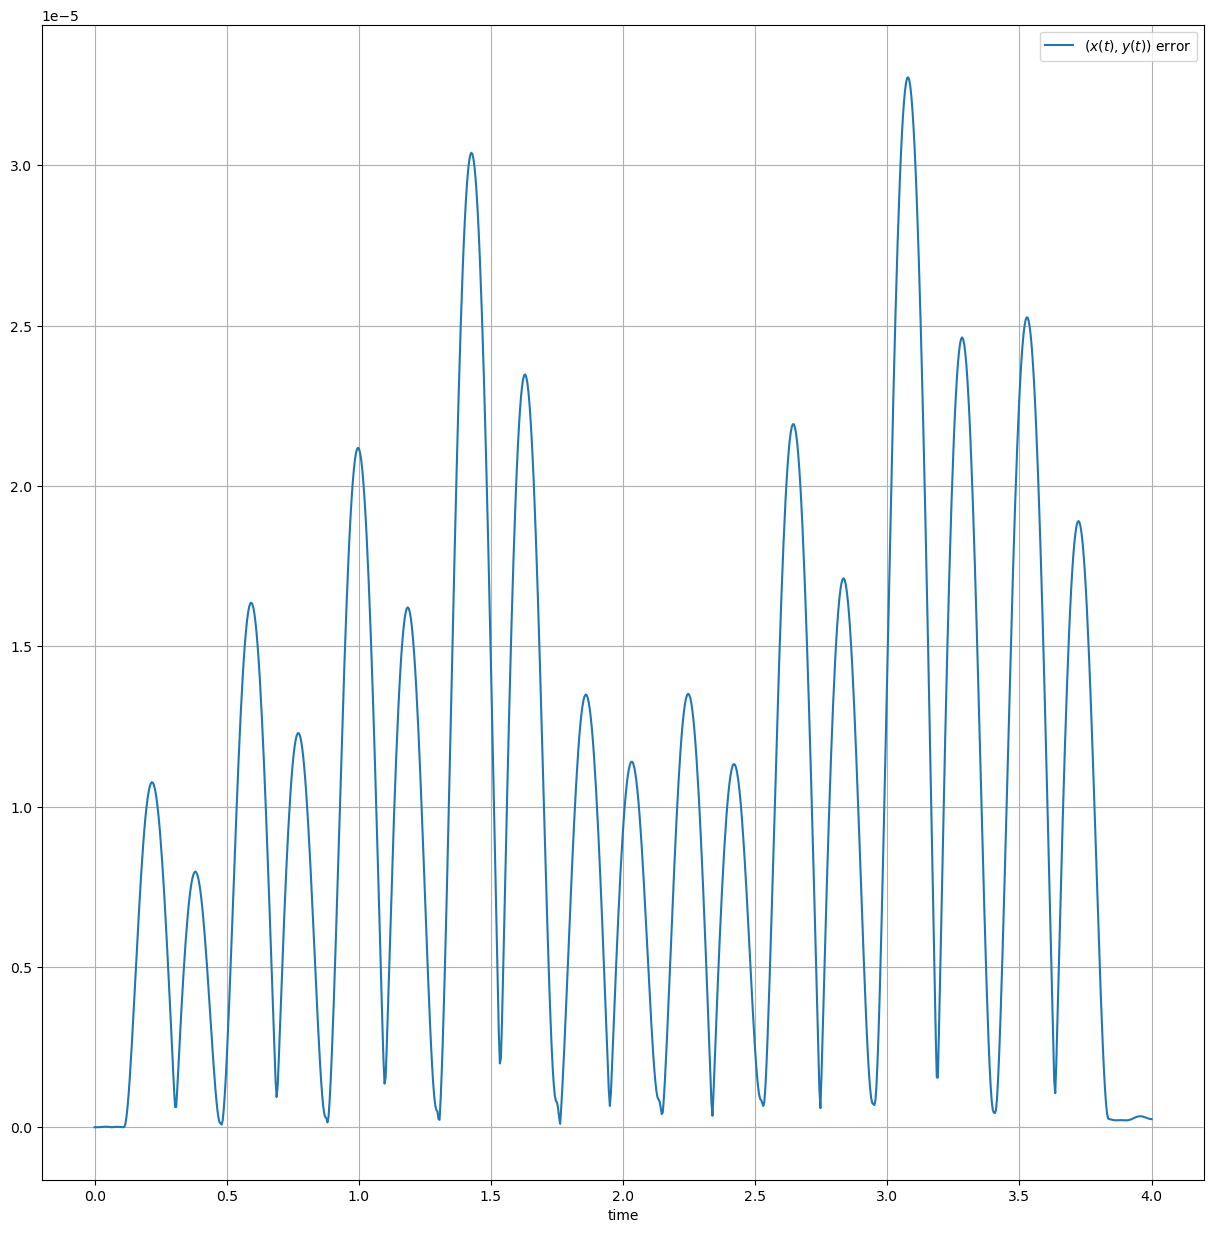

In [12]:
results = solve_ivp(
    fun=fun,
    t_span=(0.0, 4.0),
    y0=[0.0, 0.0, 0.0],
    rtol=1e-6,
    atol=1e-6,
    dense_output=True
)
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = results["sol"](t)
figure(figsize=(15, 15))
grid(True)
plot(t , sqrt((x_t - 2*sin(2*pi*t/4))**2 + (y_t + 2*cos(2*pi*t/4) - 2)**2) , label="$(x(t), y(t))$ error")
legend()
grid(True)
xlabel("time")
pass

Step 2 - Control Implementation
===============================

Time dependent inputs
---------------------

We are going to simulate the case of the scooter controlled by time-dependent angular velocities $\omega_l$ and $\omega_r$.
We want a simulation lasting 5 seconds with the following inputs:
$$
    \omega_l(t) = \left\{
       \begin{array}{rl}
           (1 - \ell/4) \pi / r & \mbox{when $t \leq 1 \,  \mathrm{s}$ or  $t \geq 3 \,  \mathrm{s}$,} \\
           (1 + \ell/4) \pi / r & \mbox{otherwise.}
       \end{array}
    \right.
$$
and
$$
    \omega_r(t) = \left\{
       \begin{array}{rl}
           (1 + \ell/4) \pi / r & \mbox{when $t \leq 1 \,  \mathrm{s}$ or $t \geq 3 \,  \mathrm{s}$,} \\
           (1 - \ell/4) \pi / r & \mbox{otherwise.}
       \end{array}
    \right.
$$

##### 🧩 Provide the new definition of `omega`

In [13]:
# 🔓
def omega(t, xytheta):
    if t <= 1 or t >= 3:
        omega_l = (1 - l/4) * pi / r
        omega_r = (1 + l/4) * pi / r
    else:
        omega_l = (1 + l/4) * pi / r
        omega_r = (1 - l/4) * pi / r
    return array([omega_l, omega_r])

##### 🧩 Make a simulation of 4 sec of the robot with the previous input. Use the `rtol` and `atol` that used to guarantee a precision of $1 \, \mathrm{mm}$ and by using the `dense_output` option to evaluate the solution at timesteps that will be defined later.

🗝️ **Hint.** It is not necessary to define again the function `fun`. If the previous cell has been correctly validated, `fun` will use the new definition of `omega`.  

In [14]:
# 🔓
tf = 4
results = solve_ivp(fun=fun, y0=[0,0,0], t_span=[0,tf], rtol=1e-6, atol=1e-6, dense_output=True)

🧩 Use the simulation results to display the robot location every 0.5 seconds.

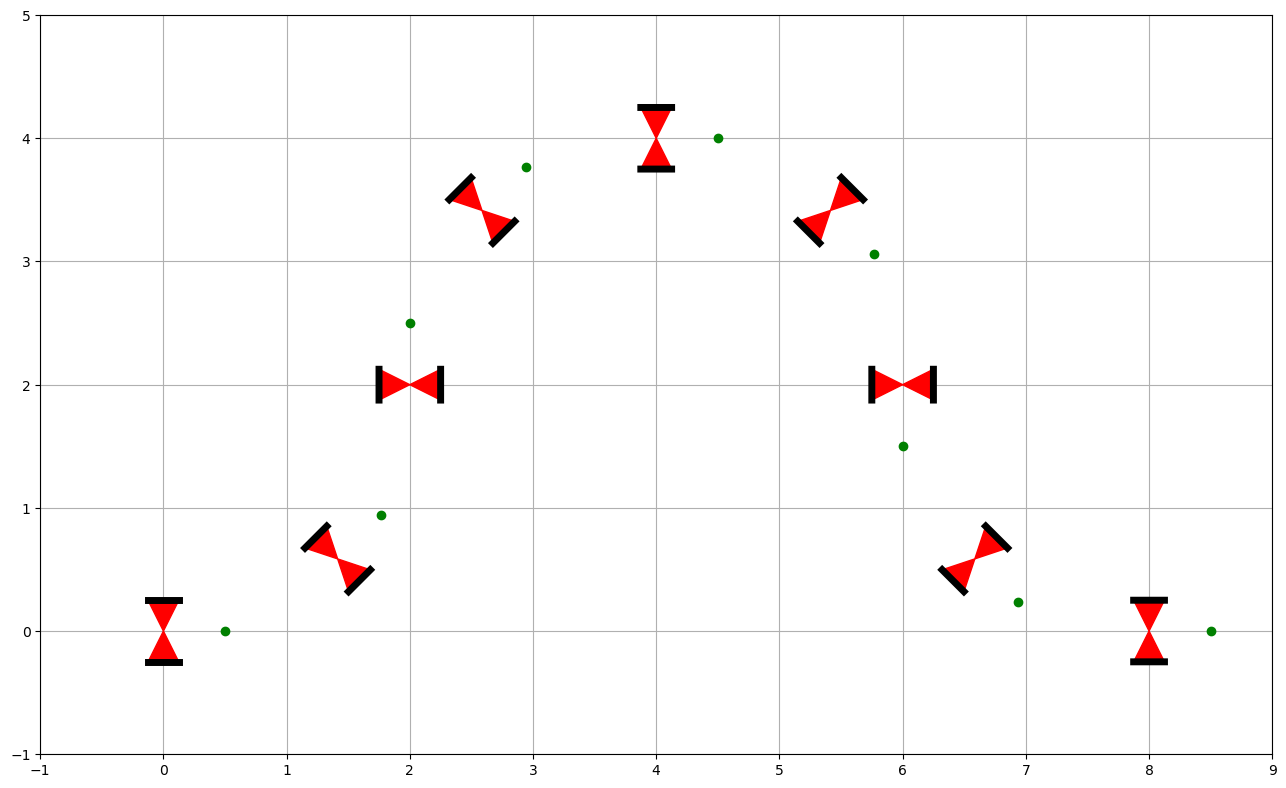

In [15]:
# 🔓
step = 0.5
t = arange(0,tf+step,step)
sol_t = results["sol"](t)
draw_arena(-1, 9, -1, 5)
for x, y, theta in sol_t.T:
    draw_scooter(x, y, theta)

## Analysis of the system at rest

### Equilibrium

##### 🧩 Show that for a suitable (constant) choice $\omega_e \in \mathbb{R}^2$ of the vector input $\omega$, the state $X_e = (x_e, y_e, \theta_e) = (0,0,0)$ is an equilibrium of the scooter kinematic model.

🔓 **Answer.** If $\omega_e=(0,0)$, $f(X_e)=0$ ($X_e=(0,0,0)$), and so $X_e$ is an equilibrium.

##### 🧩 Show that for any other $\omega_e$, the system has no equilibrium.

🔓 **Answer.** If $\omega_l\neq 0$ or $\omega_l\neq 0$, two cases:

  1. $\omega_l\neq-\omega_r$ which is different from zero, thus $\dot{x}=\dot{y}=0$ implies $\cos\theta=\sin\theta=0$ which is impossible.
  2. $\omega_l=-\omega_r$ which is different from zero, thus $\dot{\theta} = 2\omega_r\frac{\ell}{r} \neq 0$

So, there is no equilibrium if $\omega \neq \omega_e$

##### 🧩 Conversely, if $\omega = \omega_e$, what are the other equilibria of the system?

🔓 **Answer.** If $\omega=\omega_e$, then $\forall X\in\mathbb{R}^3,f(X) = 0$. Every position is an equilibrium (actually, the system is at rest)

### Linearized System Model


Let $\omega = \omega_e$ and $X_e = (0,0,0)$. Let us introduce the the error variable $\Delta X = (\Delta x, \Delta y, \Delta \theta) = X - X_e$ and $\Delta \omega = \omega - \omega_e$.

##### 🧩 Compute the corresponding linearized dynamics and put it in standard form: compute the matrices $A$ and $B$ (remember that $\omega = (\omega_l,\omega_r)$).

🔓 **Answer.**

$$
A= \begin{bmatrix} 0 & 0 &0 \\ 0 & 0 &0 \\ 0 & 0 & 0\end{bmatrix}
$$
and
$$
B= \begin{bmatrix} \frac{r}{2} & \frac{r}{2}  \\ 0 & 0 \\ -\frac{r}{\ell} & \frac{r}{\ell} \end{bmatrix}
$$

### Stability of the linearized system

##### 🧩 Is the linearized system asymptotically stable around $(0,0,0)$ when $\Delta \omega = (0,0)$ ?

🔓 **Answer.** No, with the chosen $\Delta \omega$, we have $\dot X = AX$ and $A$ has three null eigenvalues. To have a positive answer, we expected each eigenvalue to have a strictly negative real part.

##### 🧩 Is the original system asymptotically stable ? Or even (locally) attractive ?

🔓 **Answer.** With $\omega = \omega_e$, the system cannot "move". If $X(t_0) = X_0$, then $\forall t>0, X(t) =X_0$. Thus, if $X_0\neq (0,0,0)$, $X(t)$ does not converge to the origin: the original system is not (even locally) attractive.

As a consequence, it is not asymptotically stable.

### Controllability of the linearized system

In this section, we consider only the linearized system defined by the matrices $A$ and $B$ computed previously:

$$
\frac{\Delta X}{dt} = A \Delta X + B\Delta u
$$

##### 🧩 Is there an admissible trajectory that start with the state $X_0=(-2,0,0)$ and ends at origin after some time?  

🔓 **Answer.** Yes, with $\omega \propto (1,1)$, the scooter will move in straight line on the (Ox) axis and will reach the origin after some time depending on the speed.

##### 🧩 Is there an admissible trajectory that start with the state $X_0=(0,2,0)$ and ends at origin after some time?  

🔓 **Answer.** No. According to $A$ and $B$, we have $d{\Delta y}/dt=0$ and so, the error on $y$ cannot be changed by $u$.

##### 🧩 Is the linearized system controllable?

🔓 **Answer.** No, 2 possible proofs:

1. Kalman criteria: the controllability matrix has the same rank of $B$ (since $A =0$) which is 2.

2. We found that some points are not reachable with specific initial condition.

## Control on a straight line

### Admissible trajectories

Let $x_R(t) = v t$ and $y_R(t) = 0$ where $v \in \mathbb{R}$ and $v \neq 0$.

##### 🧩 Determine the set of trajectories $X_R(t) = (x_R(t), y_R(t), \theta_R(t))$ which are admissible and compute the corresponding reference control $\omega_{R}(t)$.

🔓 **Answer.** $y_R(t) = 0 \Rightarrow$ $\sin\theta_R = 0$ or $(\omega_l+\omega_r)/2 = 0$. The second case leads to $\dot{x}=0$ which is in contradiction with $\dot x_R = v$.
Thus, $\theta_R(t) = k\pi$. By continuity ($\theta$ cannot jump from $k\pi$ to $k'\pi$), this defines several sets of solutions in which $\theta_R(t)$ is constant and equal to $k\pi$. This leads to $\dot\theta=0$ and so $\omega_l(t)=\omega_r(t)=\omega(t)$

Finally, $\dot x = r \omega(t)\cos k\pi$.

We have actually 2 true sets of solutions (all the other sets will lead to the same control):

1. $X_R(t) = (vt ,0, 0)$ with a reference control $\omega_R(t)=(+v/r,+v/r)$
1. $X_R(t) = (vt ,0, \pi)$ with a reference control $\omega_R(t)=(-v/r,-v/r)$.

### Linearized system

Let $\Delta X(t) = X(t) - X_R(t)$ and $\Delta \omega(t) = \omega(t) - \omega_R(t)$.

##### 🧩 Compute the linearized dynamics of the system for the class of trajectory "moving forward".

🔓 **Answer.**

$$
  A = \begin{bmatrix}
      0 & 0 & 0 \\
      0 & 0 & v \\
      0 & 0 & 0
  \end{bmatrix}
$$

and

$$
   B=\begin{bmatrix}
    \frac{r}{2} & \frac{r}{2}  \\ 0 & 0 \\ -\frac{r}{\ell} & \frac{r}{\ell}
  \end{bmatrix}
$$

##### 🧩 Is the system asymptotically stable, with $\Delta\omega(t)=0$?

🔓 **Answer.** No since $A$ has 3 null eigenvalues.

##### 🧩 Is the system attractive, with $\Delta\omega(t)=0$?

🔓 **Answer.** No. Two possible justifications:
1. With an argument of the course: for linear system, locally attractive is equivalent to GAS. The system is not GAS (previous question).
2. By looking the system: e.g. the error $\Delta y$ remains constant without any input correction.

##### 🧩 Show that the linearized system is controllable.

🔓 **Answer.** We just study the rank of $C' = [B, AB]$ since $A^i=0$ for $i\geq2$

$$C'=
\begin{bmatrix}
    \frac{r}{2} & \frac{r}{2} & 0 & 0 \\
    0 & 0 & -v \frac{r}{\ell} & v \frac{r}{\ell} \\
    -\frac{r}{2} & \frac{r}{2} & 0 & 0
\end{bmatrix}
$$

The submatrix defined by keeping the 3 first columns if full rank. So, the controllability matrix is also full rank and the system is controllable.

### Linearized system implementation

In the sequel, we will use $v=25 \mbox{ km/h}$.

##### 🧩 Implement and print the matrices $A$ and $B$

In [16]:
v = 25 / 3.6
A = array([[0, 0, 0], [0, 0, v], [0, 0, 0]])
B = array([[r/2, r/2], [0, 0], [-r/l, r/l]])
print(A)
print(B)

[[0.         0.         0.        ]
 [0.         0.         6.94444444]
 [0.         0.         0.        ]]
[[ 0.0625  0.0625]
 [ 0.      0.    ]
 [-0.25    0.25  ]]


The linear model has to be fed with some $\Delta\omega$ input. Like for the nonlinear system, we define a function $\Delta\omega(t,\Delta_X)$ that computes the input of the linearized system. For example, if we do not want any correction to the reference input, we set:

In [17]:
def deltaOmega(t, deltaX):
    return array([0, 0, 0])

##### 🧩 Using this function `deltaOmega`, define a function `lin_fun` that computes $d{\Delta X}/dt$ given the arguments `t` and `deltaX`$.

In [18]:
# 🔓
def lin_fun(t, deltaX):
    return A @ deltaX + B @ deltaOmega(t, deltaX)

### Controller Design on the linearized system

##### 🧩 Implement a process that computes a gain matrix $K$ that places the poles of the linearized system at some arbitrary location.

For this question, we will chose 3 real poles close to -1.0.

Then, print the poles of the closed-loop system

$$
\frac{d\Delta X}{dt}= A \Delta X + B\Delta\omega
\; \mbox{ with } \;
\Delta\omega = -K \Delta X.
$$

In [19]:
# 🔓
poles = [-1.0, -1.01, -1.02]  # Strictly negative real part
K = place_poles(A,B,poles).gain_matrix
print(K)
e,_ = eig(A - B @ K)
print(e)

[[ 8.07999995 -0.28665423 -3.99138351]
 [ 8.07999999  0.30086577  4.08861651]]
[-1.01+0.j -1.02+0.j -1.  +0.j]


##### 🧩 Simulate the linearized system during 20s, with the initial condition $\Delta X(0) = (0,2,0)$.

In [20]:
def deltaOmega(t,deltaX):
    return -K @ deltaX

tf = 20
results = solve_ivp(
    fun=lin_fun,
    t_span=[0, tf],
    y0=[0, 2, 0],
    dense_output=True,
    rtol=1e-6,
    atol=1e-6
)

🧩 Plot the values of $\Delta x(t)$, $\Delta y(t)$ and $\Delta\theta(t)$ (**plot $\Delta\theta(t)$ in degrees**)

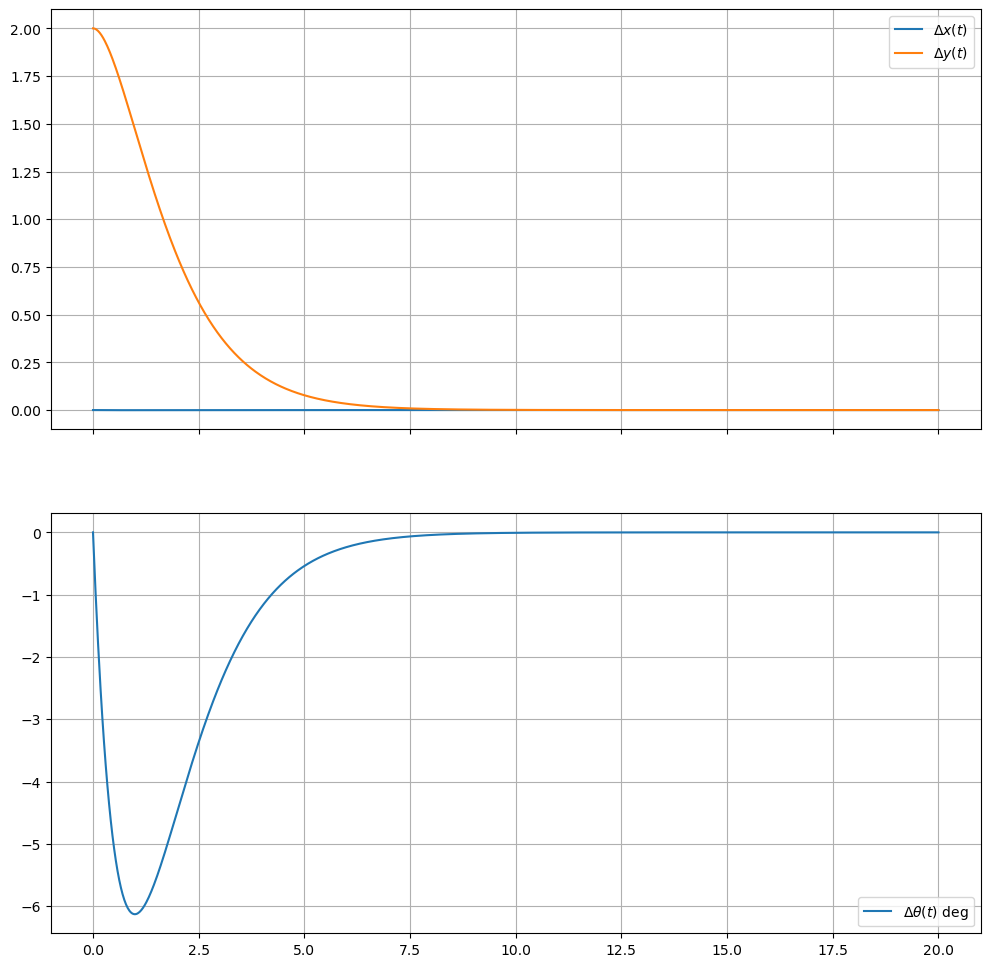

In [21]:
t = linspace(0.0, tf, 1000)
dx, dy, dtheta = results["sol"](t)
fig = figure(figsize=(12, 12))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label=r"$\Delta x(t)$")
ax1.plot(t, dy, label=r"$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$ deg")
ax2.legend()
None

##### 🧩 Why is it important to check that $\Delta\theta(t)$ stays small ?

🔓 **Answer.** The heading angle is the source of non linearity. To preserve the quality of the linearization, it is important that the error is small.

##### 🧩 Compute the corresponding values of $\Delta\omega_l,\Delta\omega_r$ and store them in the Python variables `dOmega_l`, `dOmega_r`

In [22]:
dX = results["sol"](t)
dOmega = -K @ dX
dOmega_l = dOmega[0,:]
dOmega_r = dOmega[1,:]

##### 🧩 Compute $\omega_l,\omega_r$ and plot the translation speed of each wheels in km/h

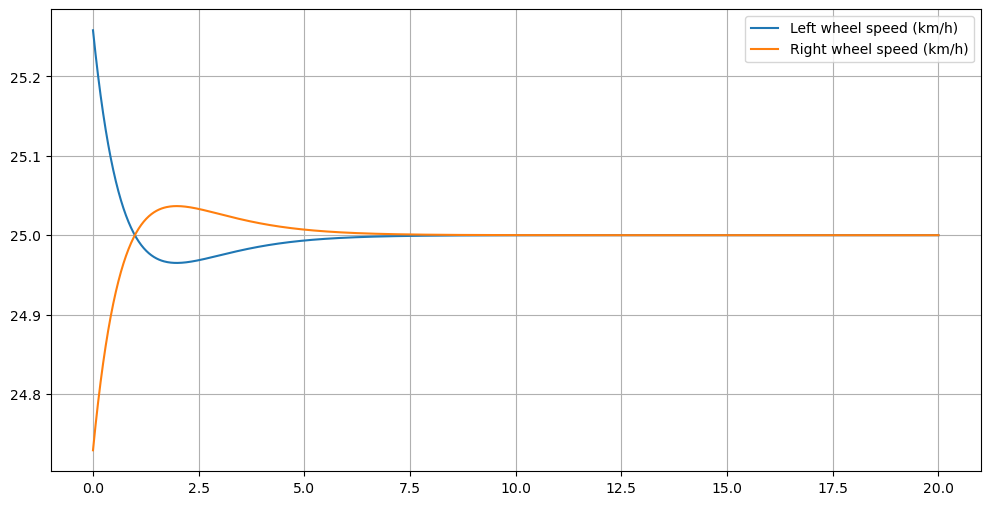

In [23]:
omega_l = dOmega_l + v/r
omega_r = dOmega_r + v/r
fig = figure(figsize=(12, 6))
plot(t, omega_l * r * 3.6, label=r"Left wheel speed (km/h)")
plot(t, omega_r * r * 3.6, label=r"Right wheel speed (km/h)")
grid()
legend()
pass

##### 🧩 Are these control values consistent with what the robot should do to cancel the error?

🔓 **Answer.** If there is not any error, the target speed of both wheels is 25 km/h. This is the value to which $\omega_l$ and $\omega_r$ seem to converge. At the beginning, the robot is a little bit too high ($y>0$), so it has to turn right. To do this, the left wheel has to be faster than the right one. This is effectively what we observes, and both values are around 25 km/h.



###  Controller Tuning



##### 🧩 Tune the poles (and recompute the gain matrix) so that the actual location $(x, y)$ is within 10 cm of the desired location within 20 sec but the angle $\Delta \theta$ never exceeds $\pm 5 \, \mathrm{deg}$. Plot the values of $\Delta x$ (in m), $\Delta y$ (in m), $\Delta \theta$ (in degrees), and the speed of each wheel (in km/h)

In [110]:
tf = 20
poles = [-0.8,-0.81,-0.82]
K = place_poles(A,B,poles).gain_matrix
def deltaOmega(t,deltaX):
        return -K @ deltaX


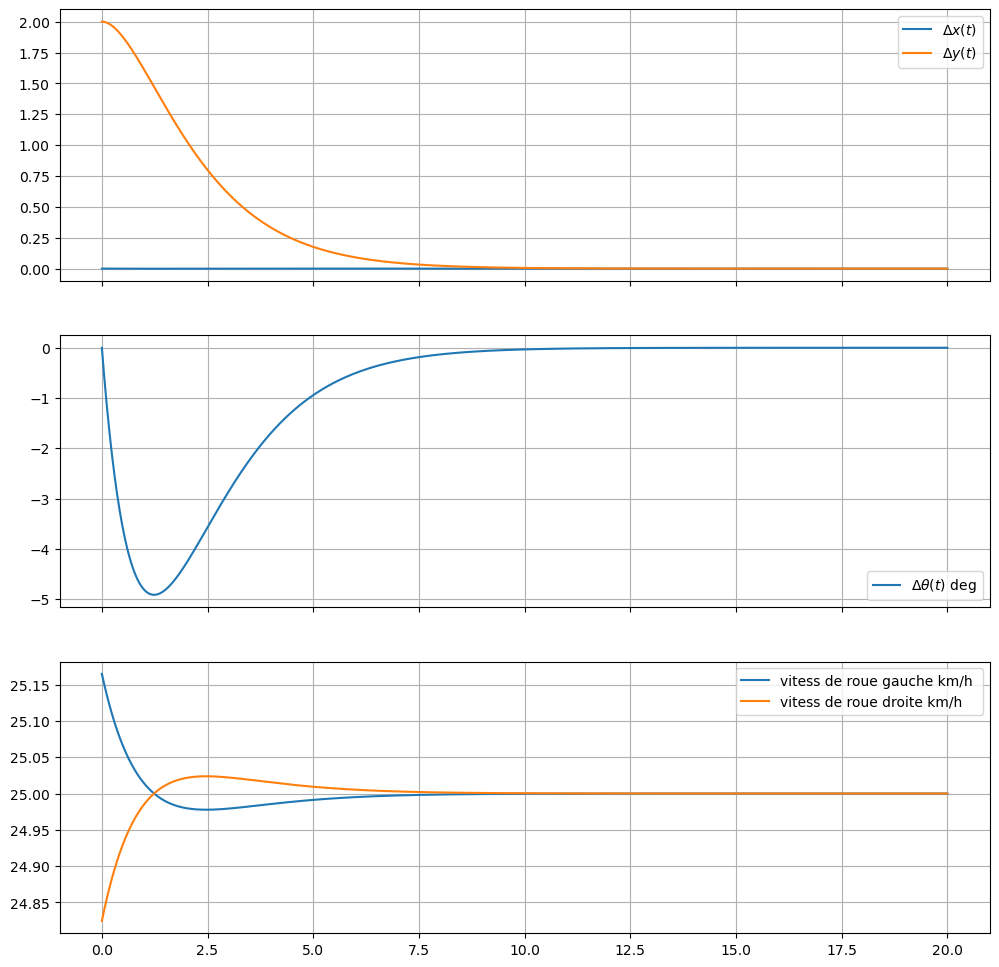

In [111]:
results = solve_ivp(
        fun=lin_fun,
        t_span=[0, tf],
        y0=[0, 2, 0],
        dense_output=True,
        rtol=1e-6,
        atol=1e-6
    )

t = linspace(0.0,tf, 1000)
dx, dy, dtheta = results["sol"](t)
fig = figure(figsize=(12, 12))
ax1, ax2 ,ax3 = fig.subplots(3, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$ deg")
ax2.legend()
ax3.grid(True)

dX = results["sol"](t)
dOmega = -K @ dX
dOmega_l = dOmega[0,:]
dOmega_r = dOmega[1,:]


omega_l = dOmega_l + v/r
omega_r = dOmega_r + v/r

ax3.plot(t, omega_l * r * 3.6, label=r"vitess de roue gauche km/h ")
ax3.plot(t, omega_r * r * 3.6, label=r"vitess de roue droite km/h ")
ax3.legend()


##### 🧩 Simulate the initial, nonlinear scooter model when the control law computed in the section "Controller Tuning" is applied. Check that the constraint given for the control law design still hold.

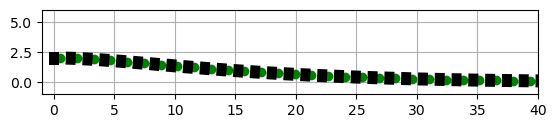

In [112]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

tf = 20
def nonlin_model(t, xytheta):
    x, y, theta = xytheta
    dX = np.array([x-v*t, y, theta]).reshape(-1, 1)
    # Control law
    dOmega = -K @ dX
    dOmega_l = dOmega[0, 0]
    dOmega_r = dOmega[1, 0]
    #change values
    dx = v * np.cos(theta)
    dy = v * np.sin(theta)
    dtheta = (dOmega_r - dOmega_l) * r / l

    return [dx, dy, dtheta]
# Run the simulation
results = solve_ivp(
    fun = nonlin_model,
    t_span=[0, 20],
    y0=[0, 2, 0],
    dense_output=True,
    rtol=1e-6,
    atol=1e-6
)

# Time steps
step = 0.2
t = np.arange(0, tf + step, step)
solution = results.sol(t)

# Plot the results
draw_arena(-1, 40, -1, 6)
for x, y, theta in solution.T:
    draw_scooter(x, y, theta)
plt.show()

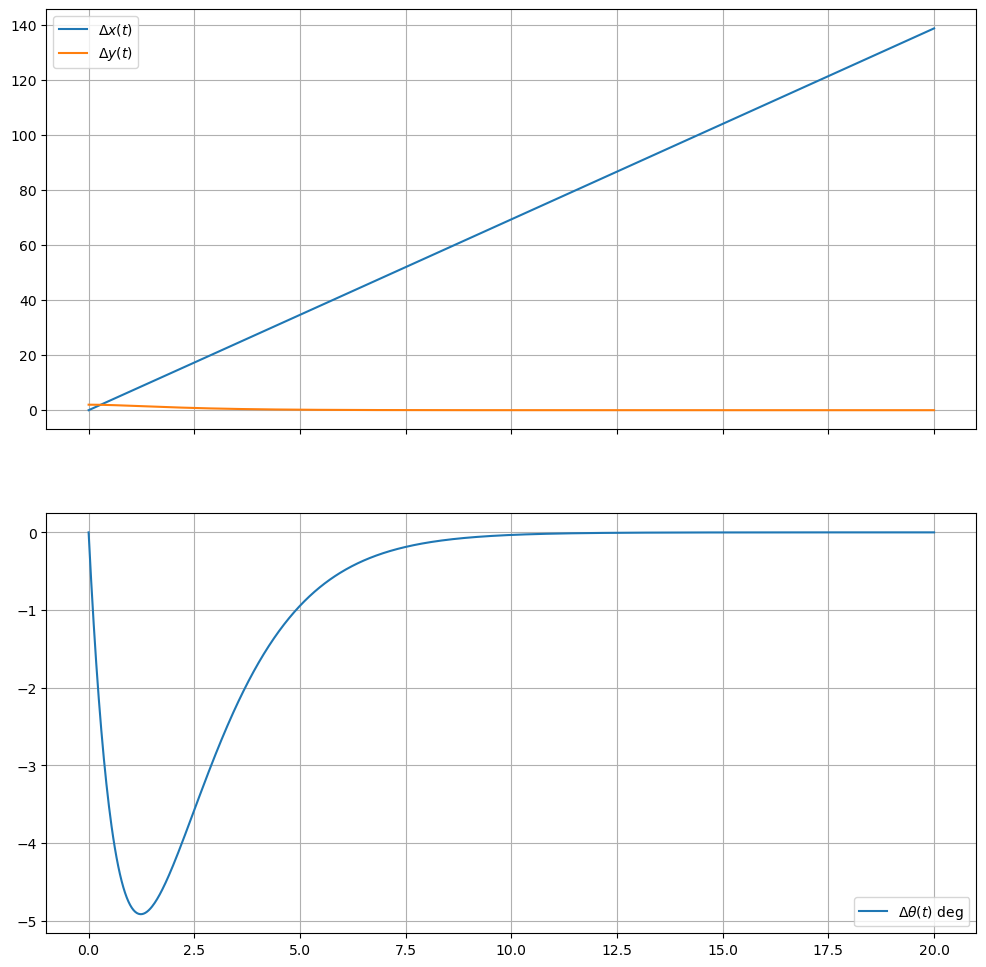

In [116]:
t = linspace(0.0,tf, 1000)
dx, dy, dtheta = results["sol"](t)
fig = figure(figsize=(12, 12))
ax1, ax2= fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$ deg")
ax2.legend()

dX = results["sol"](t)
dOmega = -K @ dX
dOmega_l = dOmega[0,:]
dOmega_r = dOmega[1,:]


omega_l = dOmega_l + v/r
omega_r = dOmega_r + v/r

##### 🧩 Display the first 5 seconds of this trajectory using a snapshot of the scooter in the plane every 0.25 second.

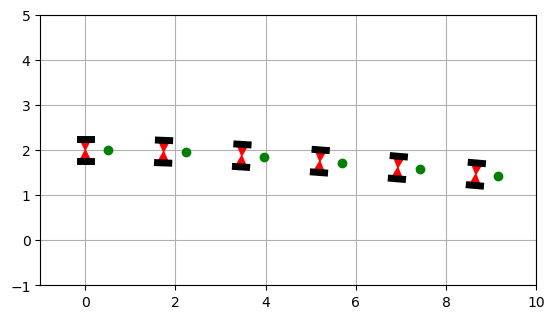

In [27]:
step = 0.25
snapshot = np.arange(0, 5 + step, step)
sol = results.sol(snapshot)
draw_arena(-1, 10, -1, 5)
for x, y, theta in sol.T:
    draw_scooter(x, y, theta)
plt.show()

Step 3 - Optimal control, Global Control and General Trajectories
=================================================================


###  Optimal control

In this part we aim to design a stabilizing controller using an optimal control methodology.

We still want to follow the reference trajectoy $x_R(t) = v t$ and $y_R(t) = 0$ where $v \in \mathbb{R}$ and $v \neq 0$ and will work with the linearized system

$$
\frac{d\Delta X}{dt}= A\Delta X + B\Delta\omega
$$

We want to find the control input $\Delta\omega$ that minimizes the quantity $J$ defined by

$$
J=\int_0^{t_f} q_1(\Delta x(t))^2 + q_2(\Delta y(t))^2 + q_3(\Delta \theta(t))^2+ r_1(\Delta \omega_l(t))^2+ r_2(\Delta \omega_r(t))^2 dt
$$

where the different constant $q_i$ and $r_i$ are strictly positive. We will denote
$$
Q=\begin{bmatrix}
      q_1 & 0 & 0 \\
      0 & q_2 & 0 \\
      0 & 0 & q_3
  \end{bmatrix}
$$
and
$$
R_0=\begin{bmatrix}
      r_1 & 0 \\
      0 & r_2 \\
  \end{bmatrix}
$$

🧩 Implement a function `Compute_cost` that computes the function $J$ for a given set of matrices $Q$ and $R$, a time horizon $t=[0,t_f]$, and for the corresponding functions $\Delta X$ and $\Delta \omega$ .
To compute the integral, you can use the function `quad` (https://docs.scipy.org/doc/scipy/tutorial/integrate.html). You may need an intermediate function that returns the quantity
$$
q_1(\Delta x(t))^2 + q_2(\Delta y(t))^2 + q_3(\Delta \theta(t))^2+ r_1(\Delta \omega_l(t))^2+ r_2(\Delta \omega_r(t))^2
$$

In [28]:
def Compute_cost(delta_X, delta_Omega):
    def func(t,delta_X, delta_Omega):
        dX = delta_X(t)
        dOmega = delta_Omega(t, delta_X(t))
        return dX.T@ Q @dX + dOmega.T@ R @dOmega
    J = quad(func, 0, tf,args=(delta_X,delta_Omega))
    return J

🧩 Test the function `Compute_cost`  with the controller you designed in the Section 'Controller Tuning' when $q_i=1$ and $r_i=1$ ($t_f=20$).

In [76]:
def delta_Omega(t,deltaX):
    return -K @ deltaX

tf = 20
Q = array([[1,0,0], [0,1,0], [0,0,1]])
R = array([[1,0],[0,1]])

result_ = solve_ivp(
    fun=lin_fun,
    t_span=[0, tf],
    y0=[0, 2, 0],
    dense_output=True,
    rtol=1e-6,
    atol=1e-6
)

Compute_cost(result_["sol"], deltaOmega)

(6.2786059655047035, 6.598999173682274e-08)

🧩 Multiply by 10 the poles and test the function `Compute_cost` in this new case. Interpret the results.

In [105]:
poles = [-8., -9, -7]
K = place_poles(A,B,poles).gain_matrix
ra = solve_ivp(
    fun=lin_fun,
    t_span=[0, tf],
    y0=[0, 2, 0],
    dense_output=True,
    rtol=1e-6,
    atol=1e-6
)

Compute_cost(ra["sol"], deltaOmega)

(83.09950054775014, 6.948668025833616e-07)

Given that the poles are further from the imaginary axis, the value of the cost function is higher than before because wee can think that primarily, both the effort and the convergence speed are more important, meaning the errors due to the state variables must be lower. conclusion: tradeoff seems not to be worth it.

🧩 Implement a process that computes a gain matrix $K$ that places the poles of the linearized system such that the quantity $J$ is minimum with "$t_f=+\infty$".

Then, for $q_i=1$, $r_i=1$, print the poles of the closed-loop system:

$$
\frac{\Delta X}{dt}= A \Delta X + B\Delta\omega
\; \mbox{ with } \;
\Delta\omega = -K \Delta X.
$$

In [106]:
Q = array([[1,0,0], [0,1,0], [0,0,1]])
R = array([[1,0],[0,1]])

Pi = solve_continuous_are(A, B, Q, R)
K = inv(R) @ B.T @ Pi
print(K)

[[ 0.70710678 -0.70710678 -4.48796781]
 [ 0.70710678  0.70710678  4.48796781]]


🧩 Plot the values of $\Delta x$ (in m), $\Delta y$ (in m), $\Delta \theta$ (in degrees), and the speed of each wheel (in km/h). Compute the value of the cost for $t_f=20$. Compare with the control law you obtained by pole assignment. Intepret the results.

-0.07969371528639586


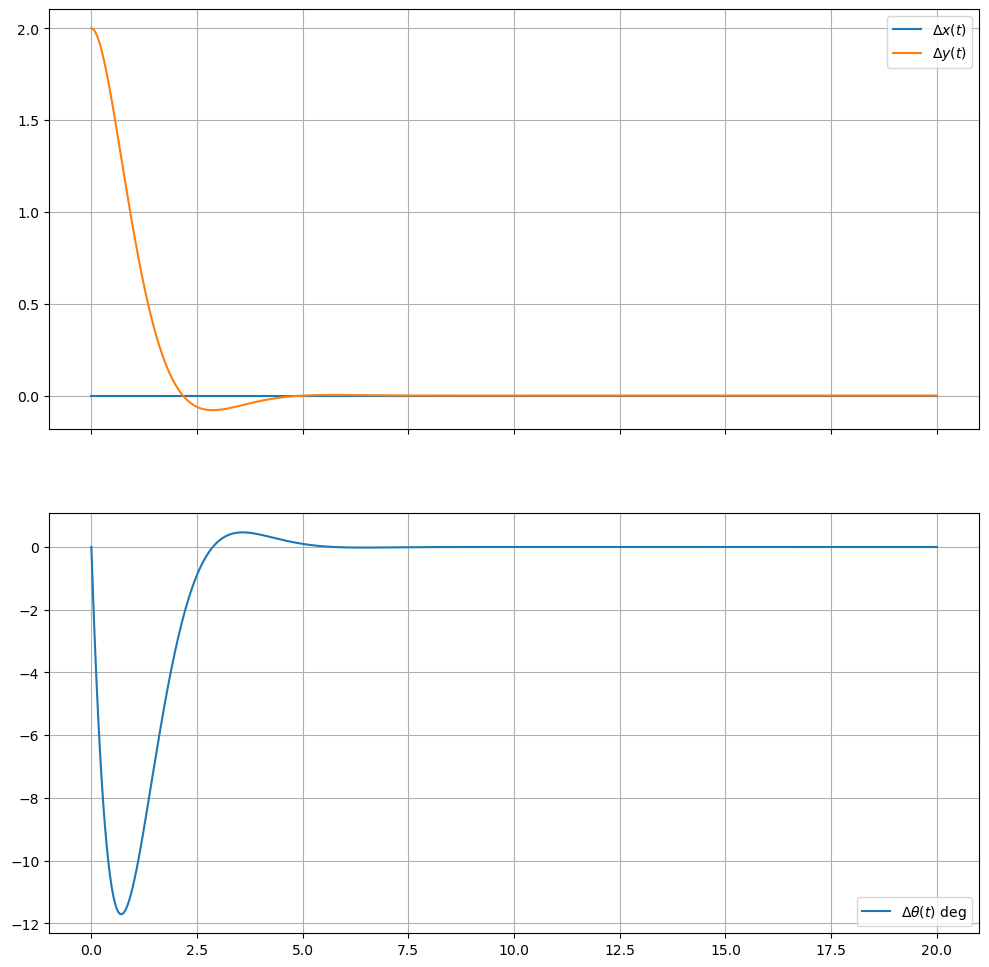

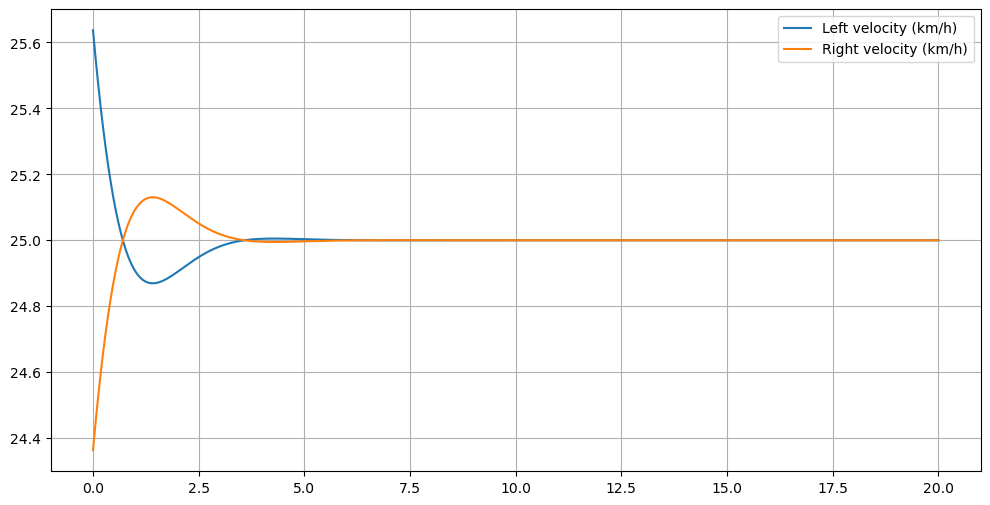

In [107]:
re = solve_ivp(
    fun=lin_fun,
    t_span=[0, 20],
    y0=[0, 2, 0],
    dense_output=True,
    rtol=1e-6,
    atol=1e-6
)

t = linspace(0.0,tf, 1000)
dx, dy, dtheta = re["sol"](t)
fig = figure(figsize=(12, 12))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$ deg")
ax2.legend()
print(min(dy))

dX = re["sol"](t)
dOmega = -K @ dX
dOmega_l = dOmega[0]
dOmega_r = dOmega[1]
omega_l = dOmega_l + v/r
omega_r = dOmega_r + v/r
fig = figure(figsize=(12, 6))
plot(t, omega_l * r * 3.6, label=r"Left velocity (km/h)")
plot(t, omega_r * r * 3.6, label=r"Right velocity (km/h)")
grid()
legend()

In [33]:
Compute_cost(re["sol"], deltaOmega)

(3.655844498200261, 5.217345384858318e-08)

We observe a decrease in the cost function, which makes sense, since K is the optimal gain!

🧩 Try large values of $Q$ then large values of $R$ and explain how these choices influence the control effort as well as the convergence speed. Do you think that both strategies will perform similarly when applied to the scooter nonlinear model? Then select $Q$ and $R$ to ensure that the scooter angle nevers exceeds 5 degrees and that $x$ and $y$ have less than 10 cm error after 20 sec.

first, let's tweak the values of Q:

-0.0663780729219037
0.125


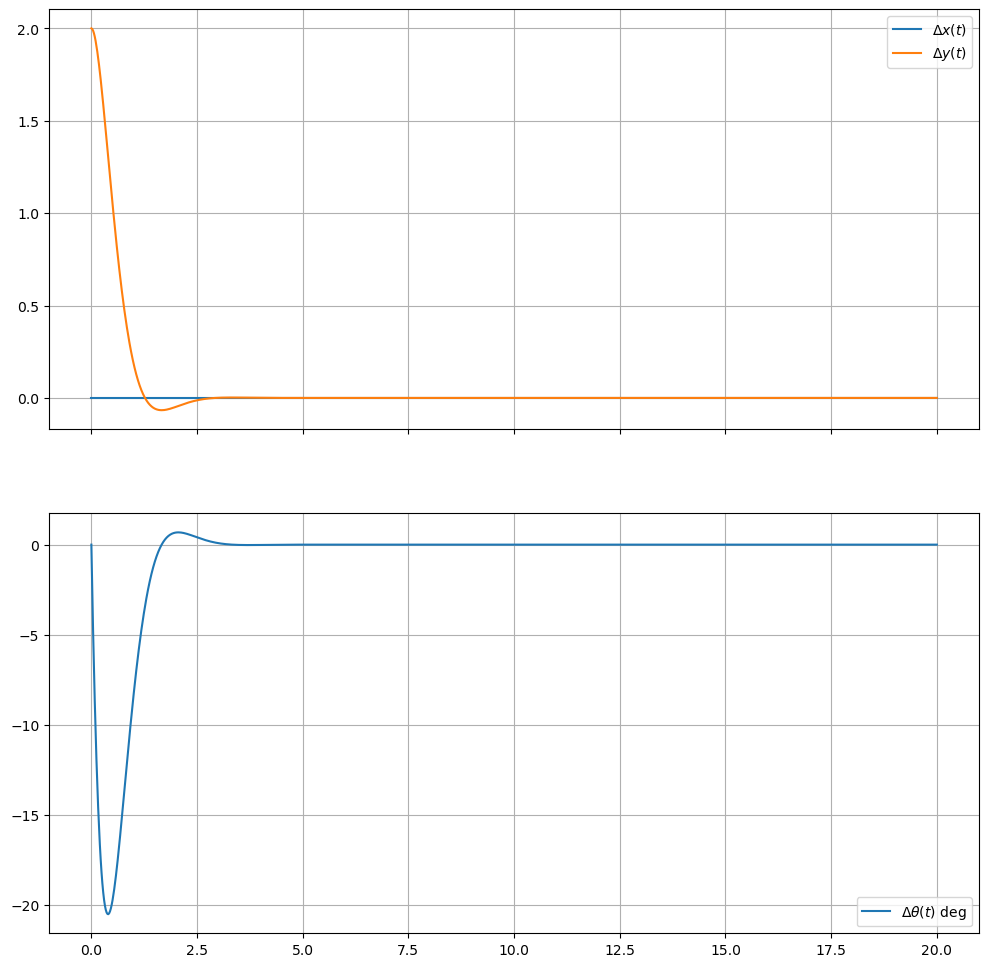

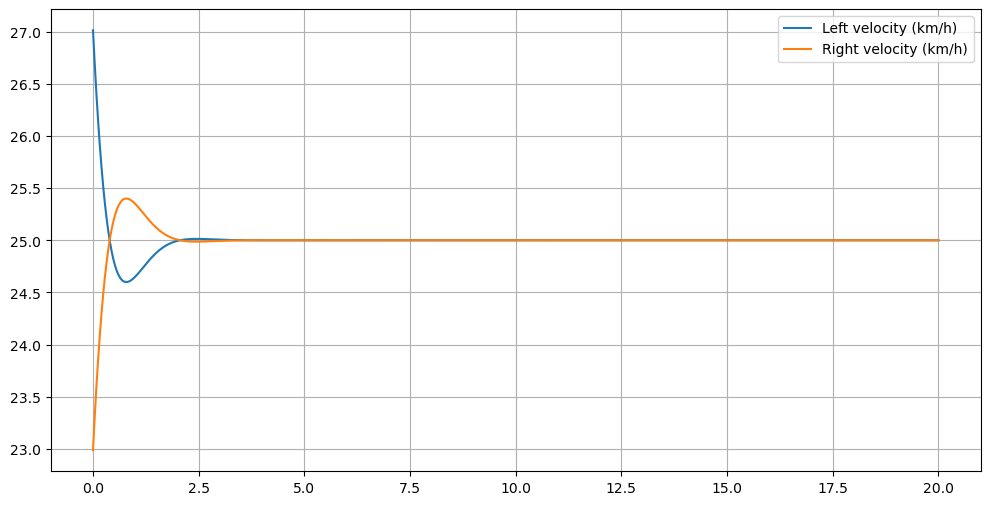

In [34]:
Q = array([[10,0,0], [0,10,0], [0,0,10]])
R = array([[1,0],[0,1]])
Pi = solve_continuous_are(A, B, Q, R)
K = inv(R) @ B.T @ Pi

re = solve_ivp(
    fun=lin_fun,
    t_span=[0, 20],
    y0=[0, 2, 0],
    dense_output=True,
    rtol=1e-6,
    atol=1e-6
)

t = linspace(0.0,tf, 1000)
dx, dy, dtheta = re["sol"](t)
fig = figure(figsize=(12, 12))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$ deg")
ax2.legend()
print(min(dy))

rr=12.5/100
print(rr)
dX = re["sol"](t)
dOmega = -K @ dX
dOmega_l = dOmega[0,:]
dOmega_r = dOmega[1,:]
omega_l = dOmega_l + v/rr
omega_r = dOmega_r + v/rr
fig = figure(figsize=(12, 6))
plot(t, omega_l * rr * 3.6, label=r"Left velocity (km/h)")
plot(t, omega_r * rr * 3.6, label=r"Right velocity (km/h)")
grid()
legend()



Let's try now with the values of R:


-0.08426113120271068
0.125


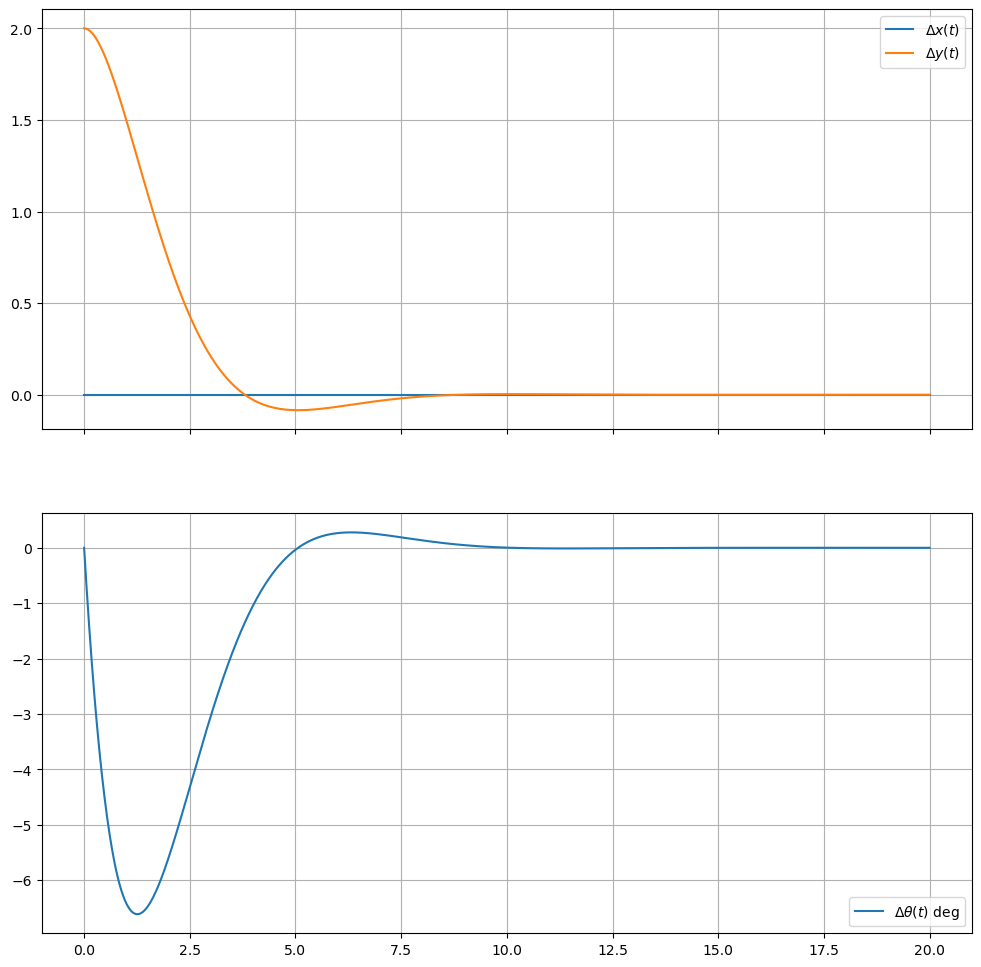

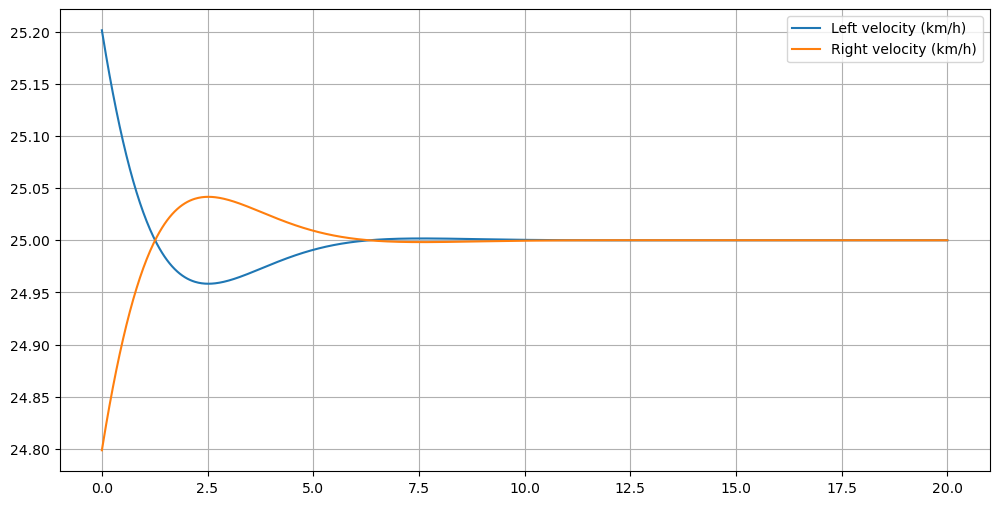

In [35]:
Q = array([[1,0,0], [0,1,0], [0,0,1]])
R = array([[10,0],[0,10]])
Pi = solve_continuous_are(A, B, Q, R)
K = inv(R) @ B.T @ Pi

re = solve_ivp(
    fun=lin_fun,
    t_span=[0, 20],
    y0=[0, 2, 0],
    dense_output=True,
    rtol=1e-6,
    atol=1e-6
)

t = linspace(0.0,tf, 1000)
dx, dy, dtheta = re["sol"](t)
fig = figure(figsize=(12, 12))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$ deg")
ax2.legend()
print(min(dy))

rr=12.5/100
print(rr)
dX = re["sol"](t)
dOmega = -K @ dX
dOmega_l = dOmega[0,:]
dOmega_r = dOmega[1,:]
omega_l = dOmega_l + v/rr
omega_r = dOmega_r + v/rr
fig = figure(figsize=(12, 6))
plot(t, omega_l * rr * 3.6, label=r"Left velocity (km/h)")
plot(t, omega_r * rr * 3.6, label=r"Right velocity (km/h)")
grid()
legend()



Interpretation of the results:
when Q takes larger parameters, more weight is attributed to the error of the position terms in the cost function. It pushes the controller to go for higher efforts with a higher convergence speed.
when R takes larger parameters, more weight is attributed to the control variables, meaning less effort with a slower convergence speed.

For the case of the nonlinear system, even though it exhibits nonlinearity, only the state variables themselves are considered. This results in influences that are qualitatively similar. But the system's nonlinearity affects it differently. In fact, we observed earlier that the system is highly sensitive to variations in theta. Therefore, in order to properly account for its influence, we need to assign higher weights to theta.

-0.08573823745572363
0.125


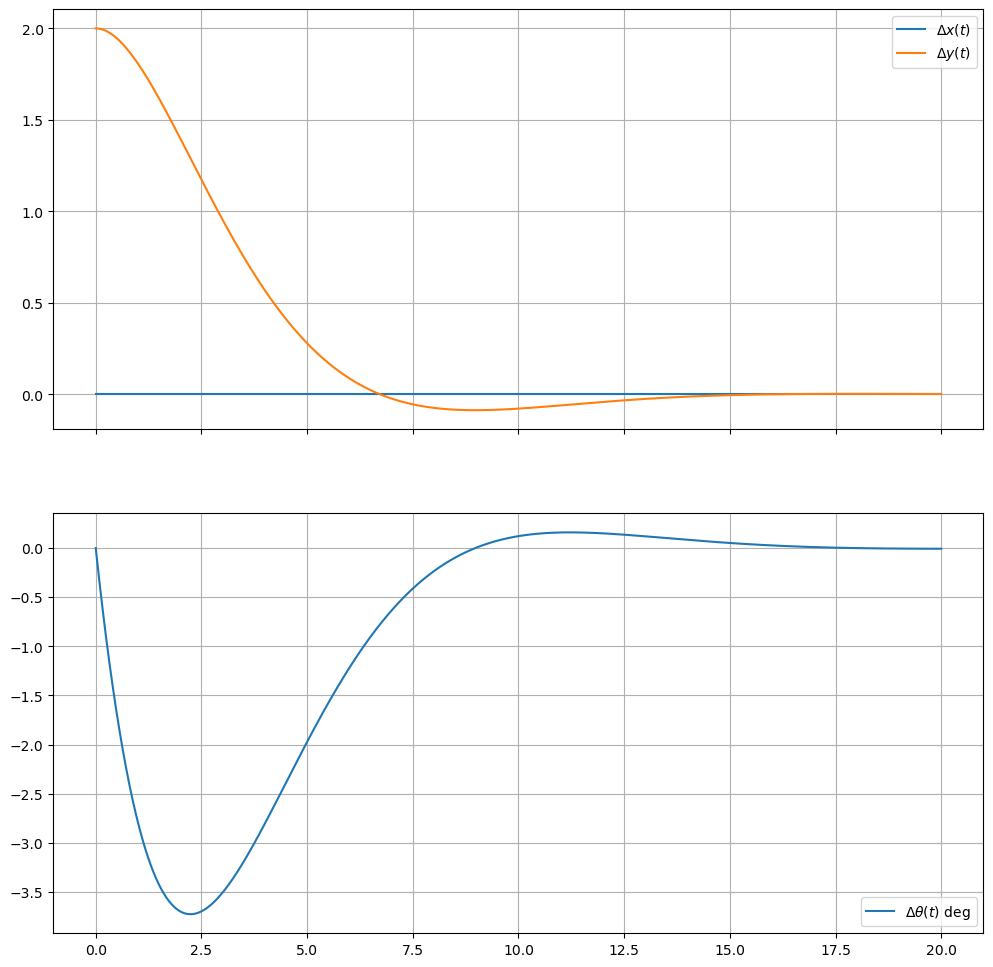

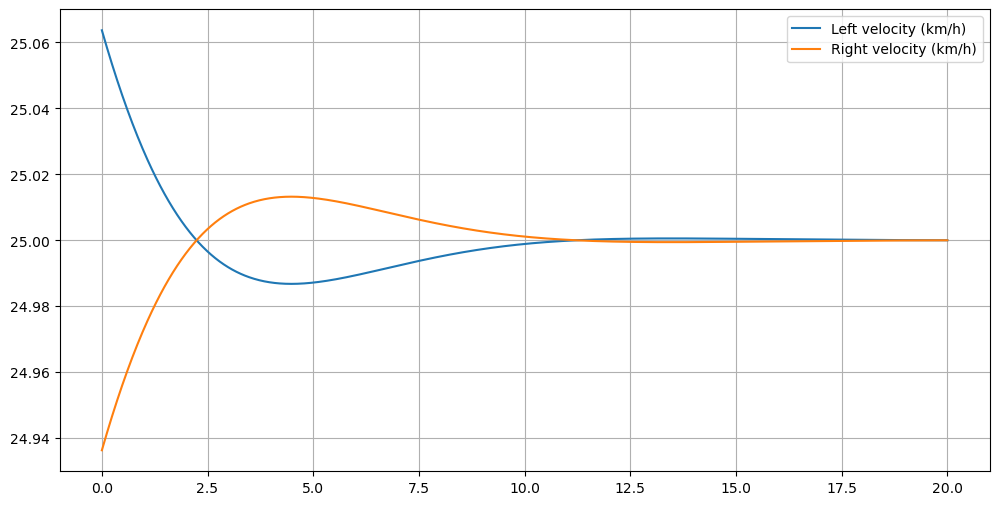

In [36]:
Q = array([[1,0,0], [0,1,0], [0,0,1]])
R = array([[100,0],[0,100]])
Pi = solve_continuous_are(A, B, Q, R)
K = inv(R) @ B.T @ Pi

re = solve_ivp(
    fun=lin_fun,
    t_span=[0, 20],
    y0=[0, 2, 0],
    dense_output=True,
    rtol=1e-6,
    atol=1e-6
)

t = linspace(0.0,tf, 1000)
dx, dy, dtheta = re["sol"](t)
fig = figure(figsize=(12, 12))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$ deg")
ax2.legend()
print(min(dy))

rr=12.5/100
print(rr)
dX = re["sol"](t)
dOmega = -K @ dX
dOmega_l = dOmega[0,:]
dOmega_r = dOmega[1,:]
omega_l = dOmega_l + v/rr
omega_r = dOmega_r + v/rr
fig = figure(figsize=(12, 6))
plot(t, omega_l * rr * 3.6, label=r"Left velocity (km/h)")
plot(t, omega_r * rr * 3.6, label=r"Right velocity (km/h)")
grid()
legend()



### Controller validation

The goal of this part is to test the optimal controller once again the **true** (nonlinear) system.

We are going to simulate the original `fun` function, but to do this, we need to define a new version of the function `omega` that computes the wheel velocities given `t` and `xytheta`.
    
🧩 Implement this new version of `omega`.

In [79]:
def omega(t,xytheta):
    return -K @ (array(xytheta) - array([v*t,0,0])) + array([v/r,v/r])

##### 🧩 Display the first 5 seconds of this trajectory using a snapshot of the scooter in the plane every 0.25 second.

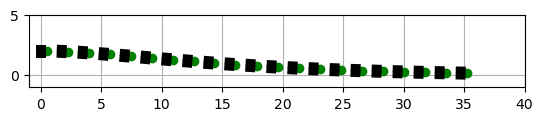

In [90]:
t_step = 0.25
t = arange(0,5+t_step,t_step)

def nonlinear_fun(t, xytheta):
    w_l, w_r = omega(t, xytheta)
    x, y, theta = xytheta
    return array([r*0.5 * (w_l + w_r) * cos(theta), r*0.5 * (w_l + w_r) * sin(theta), r * (w_r - w_l) / l])

result = solve_ivp(fun=nonlinear_fun, t_span=[0, 5], y0=[0, 2, 0], dense_output=True, rtol=1e-6, atol=1e-6)
sol = result["sol"](t)
draw_arena(-1, 40, -1, 5)

for x, y, theta in sol.T:
    draw_scooter(x, y, theta)

🧩 Make a similar drawing but add to the scooter real location the scooter reference location in the background; use the blue color to represent this "virtual" scooter.

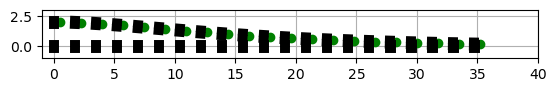

In [101]:
def draw_scooter_blue(x, y, theta):
    translation = array([[x], [y]])
    rotation = array([
        [cos(theta), -sin(theta)],
        [sin(theta),  cos(theta)]
    ])

    # Left pad
    corners = [[0, 0], [-r, l/2], [r, l/2]]
    corners += [corners[0]]
    corners = array(corners).T
    corners = rotation @ corners + translation
    xc = corners[0]
    yc = corners[1]
    fill(xc, yc, color="blue", zorder=10)

    # Right pad
    corners = [[0, 0], [r, -l/2], [-r, -l/2]]
    corners += [corners[0]]
    corners = array(corners).T
    corners = rotation @ corners + translation
    xc = corners[0]
    yc = corners[1]
    fill(xc, yc, color="blue", zorder=10)

    # Fixed Wheels
    wheel_left_xy_start = rotation @ [[-r], [-l/2]] + translation
    wheel_left_xy_end = rotation @ [[r], [-l/2]] + translation
    plot([wheel_left_xy_start[0], wheel_left_xy_end[0]], [wheel_left_xy_start[1], wheel_left_xy_end[1]], color="black",linewidth=5, zorder=20)

    wheel_right_xy_start = rotation @ [[-r], [l/2]] + translation
    wheel_right_xy_end = rotation @ [[r], [l/2]] + translation
    plot([wheel_right_xy_start[0], wheel_right_xy_end[0]], [wheel_right_xy_start[1], wheel_right_xy_end[1]], color="black", linewidth=5, zorder=20)

t_step = 0.25

snapshot = np.arange(0, 5 + t_step, t_step)
sol = results.sol(snapshot)
draw_arena(-1, 40, -1, 3)
for x, y, theta in sol.T:
    draw_scooter(x, y, theta)
for t_ in snapshot:
    draw_scooter_blue(v*t_, 0, 0)
    

🧩 Show that a tuning with a large $Q$ may work with the linear approximation but will fail on the "real" (nonlinear) model.

In [ ]:
pass

###  Marker Dynamics

The person in the scooter now tries to control its vehicle by targetting only where should be the location of the green marker ($d=50$ cm in front of the scooter center) without any regard for the angle.

🧩 Write the coordinates $(x_m, y_m)$ of this location as a function of $x$, $y$ and $\theta$.

**TODO**

🧩 Write the differential equation satisfied by $(x_m, y_m)$.

**TODO**

🧩 Show any (smooth) reference evolution of the marker $(x_f^m(t), y_f^m(t))$ and any initial state of the scooter consistent with the initial marker location, there is an admissible trajectory $(x(t), y(t), \theta(t))$ that corresponds to this reference.

🗝️ Hint: search the unique $\omega_l(t)$ and $\omega_r(t)$ – as functions of $\dot{x}_m^r(t)$, $\dot{y}_m^r(t)$ and $\theta(t)$ – that satisfies this property.

**TODO**

🧩 Let $v>0$ be the value in m/s that corresponds to $25$ km/h and let $(x_m^r(t), y_m^r(t)) = (vt, 0)$.
Simulate the scooter evolution with the choice for $\omega_l$ and $\omega_r$ of the previous question for $X(0) = (-d, 0, 0)$. Represent the scooter every second with an extra dot for the marker location.

Then, try the simulation with
$$
X(0) = (-d\cos(\alpha), -d\sin(\alpha), \alpha)
$$
for different values of $\alpha = \theta(0)$. In particular, investigate the case of à $\theta(0)$ close to $0$, then close to $\pi$). Is the system dynamics asymptotically stable in each case?

In [ ]:
pass

🧩 Consider pillars (of small radius) whose centers are aligned and distant of 2 meters, say at the locations
$$
(1.0,0), (3.0, 0), (5.0,0), \mathrm{etc.}.
$$
Compute a reference trajectory trajectory that would lead the marker from $(0,0)$ to $(6,0)$ with a slalom between the pillars. Of course, you don't want the robot frame to bump into the pillars ! Display this trajectory graphically. What happens when if the inputs $\omega_l(t)$ and $\omega_r(t)$ are applied but the robot is not initially at the expected position ?

**TODO**

In [ ]:
pass